# Distribution Lambda Layer


In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.5.0
TFP version: 0.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Probabilistic model using the `DistributionLambda` layer

We use `DistributionLambda` layer with Bernoulli Distribution as an output layer.

Note the definition of a sigmoid function is as a following : 
$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

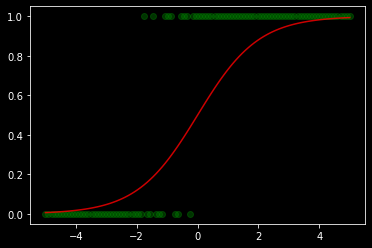

In [50]:
# Create a sigmoid model. First layer is deterministic while second layer is probabilistic
model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs = t), convert_to_tensor_fn = tfd.Distribution.sample)
])


x_plot = np.linspace(-5, 5, 100)
y_sigmoid = 1/(1 + np.exp(-x_plot))

# Plot Samples from our model.
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4, color='g')

# Plot Sigmoid Function
plt.plot(x_plot, y_sigmoid, color='r', alpha=0.8)
plt.show()

In [51]:
# Input for this model

x = np.array([[0]])
print("Input array x : ",x, x.shape)

# Intantiate the model class with input x

y_model = model(x)
y_model

# Predict output for input x. Repeat 5 times.

for _ in range(5):
    print(model.predict(x))


Input array x :  [[0]] (1, 1)
[[1]]
[[1]]
[[1]]
[[1]]
[[0]]


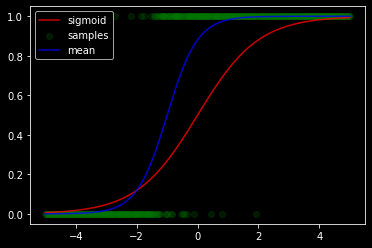

In [52]:
# Let's compare smaples and means of the probabilistic model.
# Notice the mean is somewhat off from the 'True' Sigmoid function.

# Use the model to create 500 training points
x_train = np.linspace(-5, 5, 500)[:, np.newaxis]

# Plot the Sigmoid function, the data, and the mean of the distribution.
fig, ax = plt.subplots()

# Plot the 'True' Sigmoid Function
y_train = 1/(1 + np.exp(-x_train))
plt.plot(x_plot,y_sigmoid, color='r', alpha=0.8, label = 'sigmoid')

# Plot Samples
y_model_samples = model.predict(x_train)
ax.scatter(x_train, y_model_samples, alpha=0.2, color='g', label='samples')

# Plot mean
y_model_mean = model(x_train).mean().numpy().flatten()
ax.plot(x_train, y_model_mean, 
        color='b', alpha=0.8, label='mean')

ax.legend()
plt.show()

#### Train the model with the negative loglikelihood

In [53]:
# Define negative loglikelihood, which is our loss function.

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# Compile using RMSprop

model.compile(loss = nll, optimizer = RMSprop(learning_rate=0.01))

In [54]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model.weights[0].numpy()[0, 0]]
training_bias = [model.weights[1].numpy()[0]]
for epoch in range(100):
    if epoch % 20 == 0:
        print("Current Epoch is :",epoch)
    model.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model.weights[0].numpy()[0, 0])
    training_bias.append(model.weights[1].numpy()[0])

Current Epoch is : 0
Current Epoch is : 20
Current Epoch is : 40
Current Epoch is : 60
Current Epoch is : 80


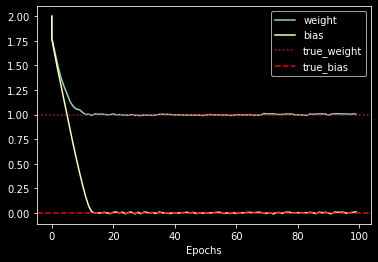

In [55]:
# Plot the model weights and biases as they train.
# Notice how the weight and bias converges.

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='r', linestyle=':')
plt.axhline(y=0, label='true_bias', color='r', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Probablistic programming with Distribution Lambda layer

Suppose we have linear datapoints with some random error, such that,

$$ y_i = x_i + \frac{3}{10}\epsilon_i$$

where $\epsilon_i $ is scattered across Normal distribution $ N(0, 1)$.

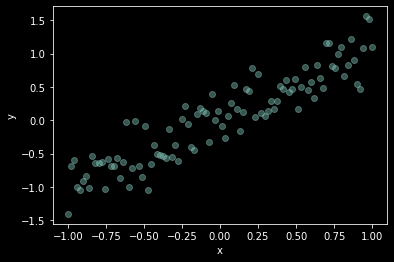

In [56]:
# Let's Create 100 data points as training data.

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 1. Deterministic linear regression with MSE loss

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


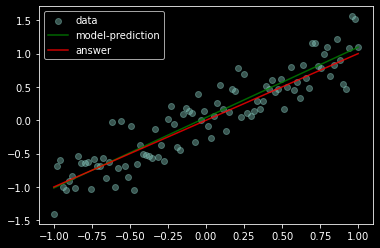

In [59]:
# Standard deterministic linear regression using MSE(mean squared error) as loss function.
from tensorflow.keras.losses import MeanSquaredError

model = Sequential([
    # Output is 1 because all we need is 1 value of y for given x.
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='g', alpha=0.8, label='model-prediction')
plt.plot(x_train, x_train, color='r', alpha=0.8, label='answer')

plt.legend()
plt.show()

In [62]:
# Examine the model predictions

x = np.array([[2]])
y = 2
prediction = model.predict(x)

y, prediction


(2, array([[2.1530359]], dtype=float32))

#### Probabilistic linear regression with mean and variance as Variables

In [63]:
# Add Normal distribution as final layer

model = Sequential([
    # Notice output units of 2. One for mean and one for variance.
    Dense(units=1+1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t[..., :1], scale=tf.math.softplus(t[...,1:]))))
])

# Instead of using DistributionLambda layer, we could also use IndependentNormal layer since our expected output is normal distribution. IndependentNormal layer has 'params_size' method which calculates output units of a previous layer before being fed into IndependentNormal layer.

# event_shape is 1 because we only need one Normal distribution as output.
event_shape = 1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape)
])

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 2)                 4         
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Train the model

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)


In [66]:
# Predict the output of single input x.

x = np.array([[0]])
model.predict(x)

array([[-0.03616881]], dtype=float32)

(100, 1) tfp.distributions.Independent("sequential_11_independent_normal_IndependentNormal_Independentsequential_11_independent_normal_IndependentNormal_Normal", batch_shape=[100], event_shape=[1], dtype=float32)
(100, 1) (100, 1)


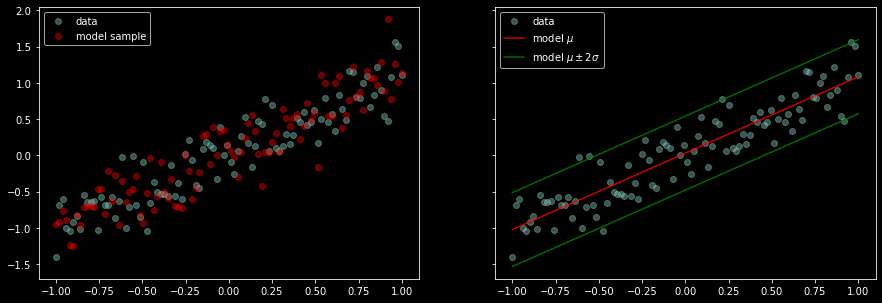

In [71]:
# Sample more points from the model.

# Keep in mind our model's output is IndependentNormal layer. As we feed in x_train, we get IndependentNormal distribution of event_shape = 1.
y_model = model(x_train)
print(x_train.shape, y_model)
# Draw Samples from our Normal Distribution.
y_sample = y_model.sample()


# Plot original data and samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()


# Plot mean and two lines for +2std -2std.
y_hat = y_model.mean() # (100, 1) means
y_sd = y_model.stddev() # (100, 1) std
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd
print(y_hat.shape, y_sd.shape)


ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear mean & variance as variables


Suppose we have nonlinear datapoints given as following : 

$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i $ is scattered across Normal distribution $ N(0, 1)$.

(1000, 1) (1000, 1)


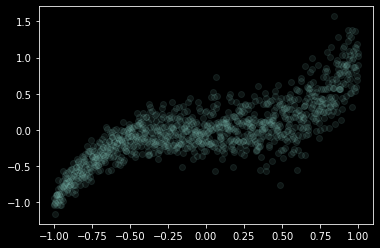

In [73]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]
print(x_train.shape, y_train.shape)

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [74]:
# Build probabilistic regression model with output of IndependentNormal distribution layer with fixed variance.

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_1 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Train the model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 6ms/step - loss: -0.1127


-0.11273084580898285

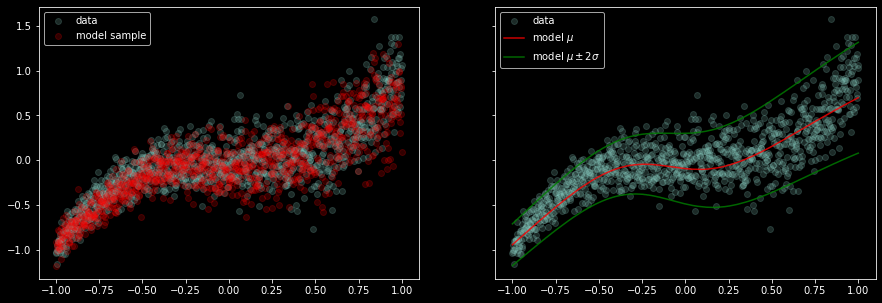

In [76]:
# Predict output Distribution from batch of inputs and draw samples from it.

# Outputs IndependentNormal distirbution layer from x_train
y_model = model(x_train)
# Draw samples from model
y_sample = y_model.sample()
# Calculate Mean from batch of x_train
y_hat = y_model.mean()
# Calculate Standard Deviation from batch of x_train
y_sd = y_model.stddev()
# Mean+2STD, Mean-2STD
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()